In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os
from datetime import datetime

In [2]:
# Set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_context("talk")

In [3]:
# Baca file CSV
file_path = '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy.csv'
df = pd.read_csv(file_path)
print(f"Memproses data untuk file {file_path}...")

Memproses data untuk file /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy.csv...


In [5]:
# Set date sebagai indeks dan konversi ke datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
# Verifikasi rentang data
print(f"Rentang data: {df.index.min()} hingga {df.index.max()}")
print(f"Total periode: {(df.index.max() - df.index.min()).days} hari")
print(f"Total baris data: {len(df)}")

Rentang data: 2005-01-01 00:00:00 hingga 2020-06-07 00:00:00
Total periode: 5636 hari
Total baris data: 3559


In [7]:
df.head(5)

,Year,Month,Day,SWRad,StDev,Max,Q,S
Date,,,,,,,,
2005-01-01,2005,Januari,1,155.61,189.97,681.56,2,5
2005-01-02,2005,Januari,2,57.16,83.72,289.75,2,5
2005-01-03,2005,Januari,3,130.86,171.20,694.65,2,5
2005-01-04,2005,Januari,4,269.79,352.19,1284.63,2,5
2005-01-05,2005,Januari,5,79.43,134.50,645.00,2,5


In [8]:
# 1. Penanganan Missing Values
print("\n--- LANGKAH 1: PENANGANAN MISSING VALUES ---")
before_cleaning = df.isna().sum()
print(f"Missing values sebelum cleaning:\n{before_cleaning}")


--- LANGKAH 1: PENANGANAN MISSING VALUES ---
Missing values sebelum cleaning:
Year      0
Month     0
Day       0
SWRad    14
StDev    14
Max      23
Q         0
S         0
dtype: int64


In [9]:
# Handle missing values berdasarkan Quality Code
def handle_missing_radiation(row):
    # Jika data radiasi hilang, tandai Q=0 (Datum Missing)
    if pd.isna(row['SWRad']):
        return 0
    return row['Q']

In [10]:
# Update Quality Code untuk data yang hilang
df['Q'] = df.apply(handle_missing_radiation, axis=1)

In [11]:
# Impute missing Max values jika SWRad dan StDev tersedia
# Menggunakan pendekatan konservatif: Max = SWRad + 2*StDev
mask = pd.isna(df['Max']) & ~pd.isna(df['SWRad']) & ~pd.isna(df['StDev'])
df.loc[mask, 'Max'] = df.loc[mask, 'SWRad'] + 2 * df.loc[mask, 'StDev']
print(f"Imputed {mask.sum()} missing Max values with conservative estimation")
print(f"Missing values setelah penanganan awal:\n{df.isna().sum()}")

Imputed 9 missing Max values with conservative estimation
Missing values setelah penanganan awal:
Year      0
Month     0
Day       0
SWRad    14
StDev    14
Max      14
Q         0
S         0
dtype: int64


In [12]:
# 2. Filtering Data Berdasarkan Quality dan Source Codes
print("\n--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---")
print(f"Distribusi Quality Code (Q):\n{df['Q'].value_counts().sort_index()}")
print(f"Distribusi Source Code (S):\n{df['S'].value_counts().sort_index()}")


--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---
Distribusi Quality Code (Q):
Q
0      14
1    1322
2    2223
Name: count, dtype: int64
Distribusi Source Code (S):
S
0      14
1    1576
5    1969
Name: count, dtype: int64


In [13]:
# Buat copy data untuk proses cleaning
df_clean = df.copy()

In [14]:
df_clean['Q'] = df_clean['Q'].astype('Int64')
df_clean['S'] = df_clean['S'].astype(int)

In [15]:
# Filter out data dengan Q=0 (datum missing) dan Q=5 (sensor failed)
df_clean = df_clean[~df_clean['Q'].isin([0, 5])]
print(f"Menghapus {len(df) - len(df_clean)} baris dengan Q=0 atau Q=5")

Menghapus 14 baris dengan Q=0 atau Q=5


In [16]:
# Prioritaskan data berdasarkan Source Code
# Jika ada duplikat timestamp, prioritaskan S=5 (Recovered from RAM) dibanding S lainnya
def prioritize_source(group):
    if len(group) == 1:
        return group
    # Prioritaskan S=5, kemudian S=1
    if 5 in group['S'].values:
        return group[group['S'] == 5].iloc[0:1]
    elif 1 in group['S'].values:
        return group[group['S'] == 1].iloc[0:1]
    else:
        return group.iloc[0:1]

In [17]:
# Check for duplicate timestamps
if df_clean.index.duplicated().any():
    print(f"Ditemukan {df_clean.index.duplicated().sum()} Date duplikat, memprioritaskan data berdasarkan Source Code")
    df_clean = df_clean.groupby(level=0).apply(prioritize_source)
    df_clean = df_clean.droplevel(1) if df_clean.index.nlevels > 1 else df_clean
else:
    print("Tidak ditemukan date atau timestamp duplikat")

Tidak ditemukan date atau timestamp duplikat


In [18]:
# 3. Deteksi dan Penanganan Outlier
print("\n--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIER ---")


--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIER ---


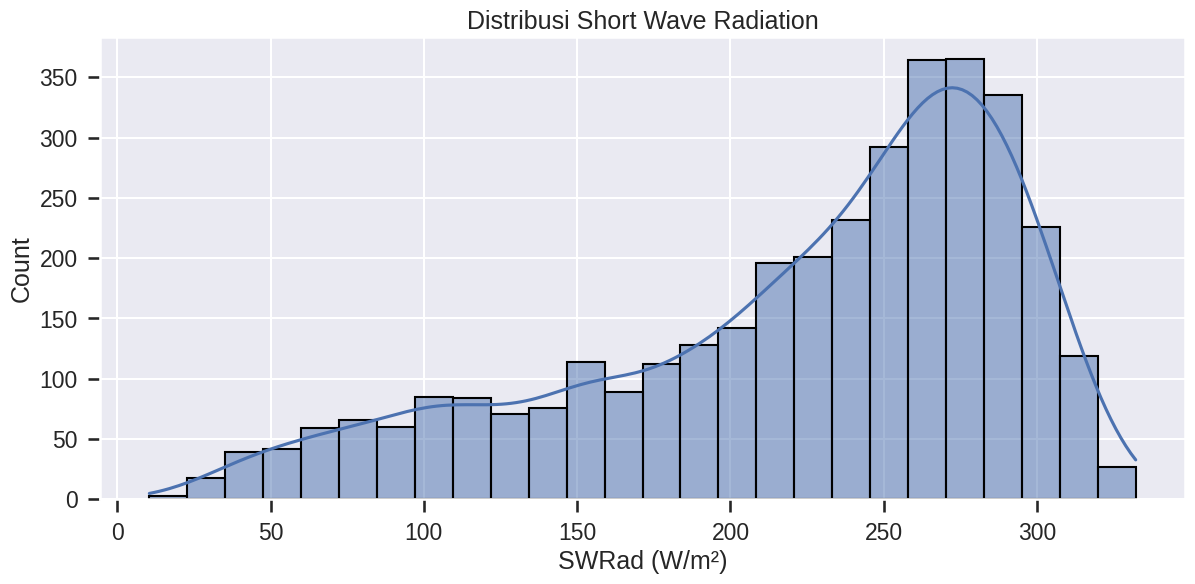

In [19]:
# Analisis distribusi SWRad
plt.figure(figsize=(14, 6))
sns.histplot(df_clean['SWRad'], kde=True)
plt.title('Distribusi Short Wave Radiation')
plt.xlabel('SWRad (W/m²)')
# plt.savefig('SWRad_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

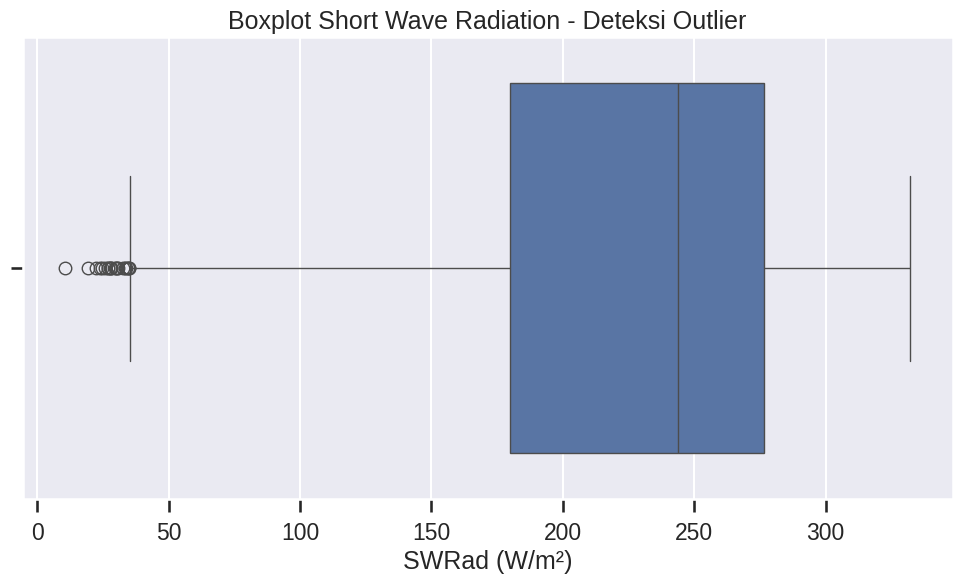

In [20]:
# Plot boxplot untuk melihat outlier
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_clean['SWRad'])
plt.title('Boxplot Short Wave Radiation - Deteksi Outlier')
plt.xlabel('SWRad (W/m²)')
# plt.savefig('SWRad_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [21]:
# Deteksi outlier menggunakan metode IQR (Interquartile Range)
Q1 = df_clean['SWRad'].quantile(0.25)
Q3 = df_clean['SWRad'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [22]:
# Hitung jumlah outlier
outliers = df_clean[(df_clean['SWRad'] < lower_bound) | (df_clean['SWRad'] > upper_bound)]
print(f"Terdeteksi {len(outliers)} outlier berdasarkan metode IQR")
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

Terdeteksi 21 outlier berdasarkan metode IQR
Lower bound: 35.21, Upper bound: 421.08


In [23]:
# Validasi outlier untuk radiasi matahari
# Radiasi matahari tidak boleh negatif dan tidak boleh melebihi konstanta matahari (~1361 W/m²)
physical_outliers = df_clean[(df_clean['SWRad'] < 0) | (df_clean['SWRad'] > 1500)]
print(f"Terdeteksi {len(physical_outliers)} outlier berdasarkan batasan fisik")


Terdeteksi 0 outlier berdasarkan batasan fisik


In [24]:
# Cek apakah ada nilai sangat ekstrem yang tidak masuk akal secara meteorologis
extreme_outliers = df_clean[df_clean['SWRad'] > 1000]
print(f"Nilai sangat ekstrem (>1000 W/m²): {len(extreme_outliers)}")

Nilai sangat ekstrem (>1000 W/m²): 0


In [25]:
# Flag outlier tapi tidak hapus, simpan informasi dalam kolom baru
df_clean['is_outlier'] = (df_clean['SWRad'] < lower_bound) | (df_clean['SWRad'] > upper_bound)
df_clean['is_physical_outlier'] = (df_clean['SWRad'] < 0) | (df_clean['SWRad'] > 1500)

In [26]:
# 4. Time Series Gap Analysis and Handling
print("\n--- LANGKAH 4: ANALISIS DAN PENANGANAN GAP TIME SERIES ---")


--- LANGKAH 4: ANALISIS DAN PENANGANAN GAP TIME SERIES ---


In [27]:
# Buat DataSeries harian yang kontinyu untuk seluruh periode
full_range = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='D')
full_df = pd.DataFrame(index=full_range)

Ditemukan 2092 gap dalam time series dari total 5637 hari
Persentase gap: 37.11%
Distribusi panjang gap:
gap_length
1      19
2       9
3       7
4       7
5       7
       ..
457     1
458     1
459     1
460     1
461     1
Name: count, Length: 461, dtype: int64


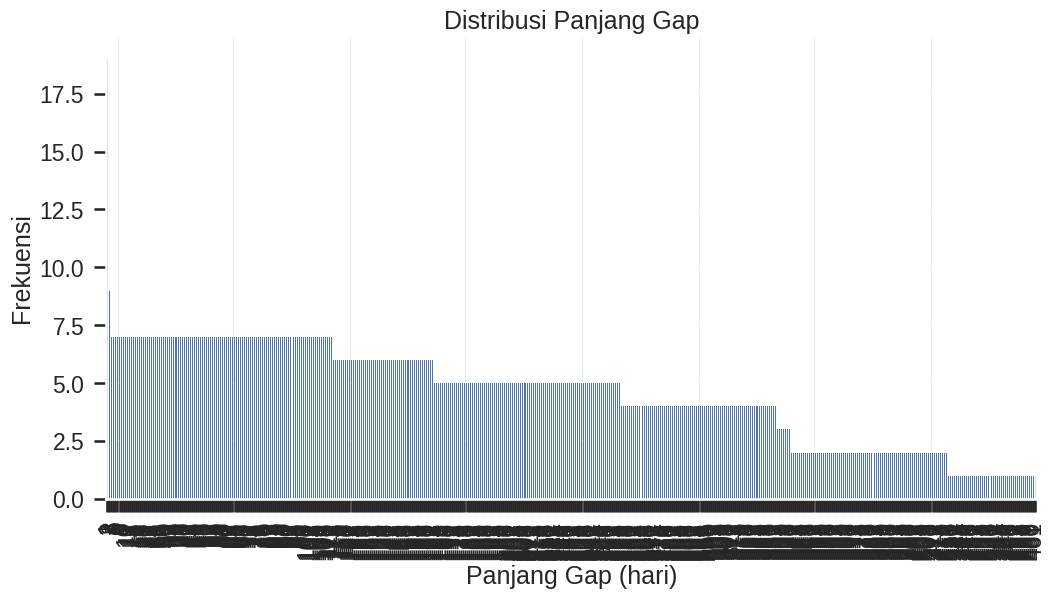

In [29]:
# Gabungkan dengan data yang sudah di-clean
merged_df = full_df.join(df_clean)
gap_count = merged_df['SWRad'].isna().sum()

print(f"Ditemukan {gap_count} gap dalam time series dari total {len(full_range)} hari")
print(f"Persentase gap: {gap_count/len(full_range)*100:.2f}%")

# Identifikasi gap berdasarkan panjangnya
merged_df['gap_length'] = merged_df['SWRad'].isna().astype(int).groupby(merged_df['SWRad'].notna().cumsum()).cumsum()
gap_lengths = merged_df[merged_df['SWRad'].isna()]['gap_length'].value_counts().sort_index()

if not gap_lengths.empty:
    print("Distribusi panjang gap:")
    print(gap_lengths)
    # Plot distribusi panjang gap
    plt.figure(figsize=(12, 6))
    gap_lengths.plot(kind='bar')
    plt.title('Distribusi Panjang Gap')
    plt.xlabel('Panjang Gap (hari)')
    plt.ylabel('Frekuensi')
    # plt.savefig('gap_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [30]:
# 5. Aplikasi Triple Exponential Smoothing (Holt-Winters)
print("\n--- LANGKAH 5: APLIKASI TRIPLE EXPONENTIAL SMOOTHING (HOLT-WINTERS) ---")


--- LANGKAH 5: APLIKASI TRIPLE EXPONENTIAL SMOOTHING (HOLT-WINTERS) ---


In [31]:
# Persiapkan time series untuk Holt-Winters
ts_data = merged_df['SWRad'].copy()

In [32]:
# Data preprocessing untuk smoothing
# Interpolasi linier untuk gap pendek (<= 7 hari)
gap_mask = merged_df['gap_length'] <= 7
if 'gap_length' in merged_df.columns and gap_mask.any():
    print(f"Melakukan interpolasi linier untuk {gap_mask.sum()} gap pendek (<= 7 hari)")
    ts_data.loc[gap_mask] = np.nan  # Pastikan gap ini nan untuk interpolasi
    ts_data = ts_data.interpolate(method='linear', limit=7)

Melakukan interpolasi linier untuk 3608 gap pendek (<= 7 hari)


In [33]:
# Simpan data sebelum smoothing untuk perbandingan
merged_df['SWRad_original'] = merged_df['SWRad'].copy()
merged_df['SWRad_interpolated'] = ts_data.copy()

In [39]:
ts_data = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)

# Ensure the Date column is in datetime format and set it as the index
ts_data['Date'] = pd.to_datetime(ts_data['Date'], errors='coerce')
ts_data.set_index('Date', inplace=True)

# Convert relevant columns to numeric types
ts_data[['SWRad', 'StDev', 'Max']] = ts_data[['SWRad', 'StDev', 'Max']].apply(pd.to_numeric, errors='coerce')

ts_data = ts_data.infer_objects()

# Fill gaps using linear interpolation
ts_data_filled = ts_data.interpolate(method='linear')

# Check the length of the filled data
print(f"Length of filled data: {len(ts_data_filled)}")
print(f"Number of non-missing data points: {len(ts_data_filled.dropna())}")


Length of filled data: 3559
Number of non-missing data points: 3559


/tmp/ipykernel_13973/1975927046.py:13: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ts_data_filled = ts_data.interpolate(method='linear')


In [40]:
if len(ts_data_filled.dropna()) > 730:  # Minimal 2 tahun data
    try:
        # Coba dengan model multiplikatif dulu (biasanya lebih cocok untuk data radiasi)
        hw_model_mul = ExponentialSmoothing(
            ts_data_filled['SWRad'], 
            seasonal_periods=365, 
            trend='add', 
            seasonal='mul',
            use_boxcox=True
        ).fit(optimized=True)
        
        print("Model Holt-Winters Multiplikatif:")
        print(f"Alpha (level): {hw_model_mul.params['smoothing_level']:.4f}")
        print(f"Beta (trend): {hw_model_mul.params['smoothing_trend']:.4f}")
        print(f"Gamma (seasonal): {hw_model_mul.params['smoothing_seasonal']:.4f}")
        print(f"Box-Cox Lambda: {hw_model_mul.params['use_boxcox']}")
        
        # Simpan parameter untuk dokumentasi
        hw_params = {
            'type': 'multiplicative',
            'alpha': hw_model_mul.params['smoothing_level'],
            'beta': hw_model_mul.params['smoothing_trend'],
            'gamma': hw_model_mul.params['smoothing_seasonal'],
            'boxcox': hw_model_mul.params['use_boxcox']
        }
        
        # Fit model ke seluruh data (termasuk gap untuk memperkirakan nilai missing)
        smoothed_values = hw_model_mul.predict(start=0, end=len(ts_data_filled)-1)
    except Exception as e:
        # Fallback ke model aditif jika multiplikatif gagal
        print(f"Model multiplikatif gagal: {e}")
        print("Menggunakan model aditif sebagai fallback")
        hw_model_add = ExponentialSmoothing(
            ts_data_filled['SWRad'], 
            seasonal_periods=365, 
            trend='add', 
            seasonal='add',
            use_boxcox=True
        ).fit(optimized=True)
        
        print("Model Holt-Winters Aditif:")
        print(f"Alpha (level): {hw_model_add.params['smoothing_level']:.4f}")
        print(f"Beta (trend): {hw_model_add.params['smoothing_trend']:.4f}")
        print(f"Gamma (seasonal): {hw_model_add.params['smoothing_seasonal']:.4f}")
        print(f"Box-Cox Lambda: {hw_model_add.params['use_boxcox']}")
        
        # Simpan parameter untuk dokumentasi
        hw_params = {
            'type': 'additive',
            'alpha': hw_model_add.params['smoothing_level'],
            'beta': hw_model_add.params['smoothing_trend'],
            'gamma': hw_model_add.params['smoothing_seasonal'],
            'boxcox': hw_model_add.params['use_boxcox']
        }
        
        # Fit model ke seluruh data
        smoothed_values = hw_model_add.predict(start=0, end=len(ts_data_filled)-1)
else:
    # Jika data kurang dari 2 tahun, gunakan Double Exponential Smoothing
    print("Data kurang dari 2 tahun, menggunakan Double Exponential Smoothing")
    
    if len(ts_data_filled.dropna()) > 0:
        hw_model = Holt(ts_data_filled['SWRad']).fit(optimized=True)
        print("Model Holt (Double Exponential Smoothing):")
        print(f"Alpha (level): {hw_model.params['smoothing_level']:.4f}")
        print(f"Beta (trend): {hw_model.params['smoothing_trend']:.4f}")
        
        # Simpan parameter untuk dokumentasi
        hw_params = {
            'type': 'double',
            'alpha': hw_model.params['smoothing_level'],
            'beta': hw_model.params['smoothing_trend']
        }
        
        # Fit model ke seluruh data
        smoothed_values = hw_model.predict(start=0, end=len(ts_data_filled)-1)
    else:
        print("Data tidak cukup untuk Double Exponential Smoothing")
        smoothed_values = ts_data_filled['SWRad']  # or handle this case as needed

# Tambahkan hasil smoothing ke DataFrame
ts_data_filled['SWRad_smoothed'] = smoothed_values

# Print the first few rows of the DataFrame to verify
print(ts_data_filled.head())

/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model Holt-Winters Multiplikatif:
Alpha (level): 0.2171
Beta (trend): 0.0001
Gamma (seasonal): 0.0626
Box-Cox Lambda: True
            Year    Month  Day   SWRad   StDev      Max  Q  S  SWRad_smoothed
Date                                                                         
2005-01-01  2005  Januari    1  155.61  189.97   681.56  2  5      292.806712
2005-01-02  2005  Januari    2   57.16   83.72   289.75  2  5      239.605336
2005-01-03  2005  Januari    3  130.86  171.20   694.65  2  5      202.906294
2005-01-04  2005  Januari    4  269.79  352.19  1284.63  2  5      217.896233
2005-01-05  2005  Januari    5   79.43  134.50   645.00  2  5      228.372775


/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [41]:
# Tambahkan hasil smoothing ke DataFrame
merged_df['SWRad_smoothed'] = smoothed_values

In [42]:
# Tambahkan hasil smoothing ke DataFrame
merged_df['SWRad_smoothed'] = smoothed_values

In [43]:
# 6. Substitusi Nilai Missing & Outlier
print("\n--- LANGKAH 6: SUBSTITUSI NILAI MISSING & OUTLIER ---")


--- LANGKAH 6: SUBSTITUSI NILAI MISSING & OUTLIER ---


In [44]:
# Substitusi nilai missing dengan hasil smoothing
missing_mask = merged_df['SWRad'].isna()
if missing_mask.any():
    print(f"Mensubstitusi {missing_mask.sum()} nilai missing dengan hasil Holt-Winters")
    merged_df.loc[missing_mask, 'SWRad'] = merged_df.loc[missing_mask, 'SWRad_smoothed']

# Substitusi physical outlier dengan hasil smoothing
if 'is_physical_outlier' in merged_df.columns:
    physical_outlier_mask = merged_df['is_physical_outlier'] == True
    if physical_outlier_mask.any():
        print(f"Mensubstitusi {physical_outlier_mask.sum()} physical outlier dengan hasil Holt-Winters")
        merged_df.loc[physical_outlier_mask, 'SWRad'] = merged_df.loc[physical_outlier_mask, 'SWRad_smoothed']

# Tandai substitusi dengan Quality Code 3 (Adjusted Data)
merged_df.loc[missing_mask | physical_outlier_mask, 'Q'] = 3

Mensubstitusi 2092 nilai missing dengan hasil Holt-Winters


In [45]:
# 7. Plot hasil preprocessing
print("\n--- LANGKAH 7: VISUALISASI HASIL PREPROCESSING ---")


--- LANGKAH 7: VISUALISASI HASIL PREPROCESSING ---


In [46]:
# Plot time series untuk perbandingan data asli vs smoothed vs cleaned
def plot_ts_comparison(start_date=None, end_date=None, title_suffix=""):
    data_subset = merged_df
    
    if start_date and end_date:
        # Filter untuk rentang waktu tertentu
        data_subset = merged_df.loc[start_date:end_date]
    
    plt.figure(figsize=(16, 8))
    
    # Plot data original (dengan gap)
    plt.plot(data_subset.index, data_subset['SWRad_original'], 'o', 
             alpha=0.5, label='Original Data', markersize=2)
    
    # Plot data setelah interpolasi linear
    plt.plot(data_subset.index, data_subset['SWRad_interpolated'], '-', 
             alpha=0.7, label='After Linear Interpolation', linewidth=1)
    
    # Plot hasil smoothing
    plt.plot(data_subset.index, data_subset['SWRad_smoothed'], '-', 
             label='Holt-Winters Smoothed', linewidth=2)
    
    # Plot data final setelah cleaning
    plt.plot(data_subset.index, data_subset['SWRad'], 'r.', 
             alpha=0.7, label='Final Cleaned Data', markersize=3)
    
    plt.title(f'Perbandingan Data Original vs Cleaned {title_suffix}')
    plt.xlabel('Tanggal')
    plt.ylabel('Short Wave Radiation (W/m²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Simpan plot
    filename = f"SWRad_comparison{'_' + title_suffix.replace(' ', '_') if title_suffix else ''}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

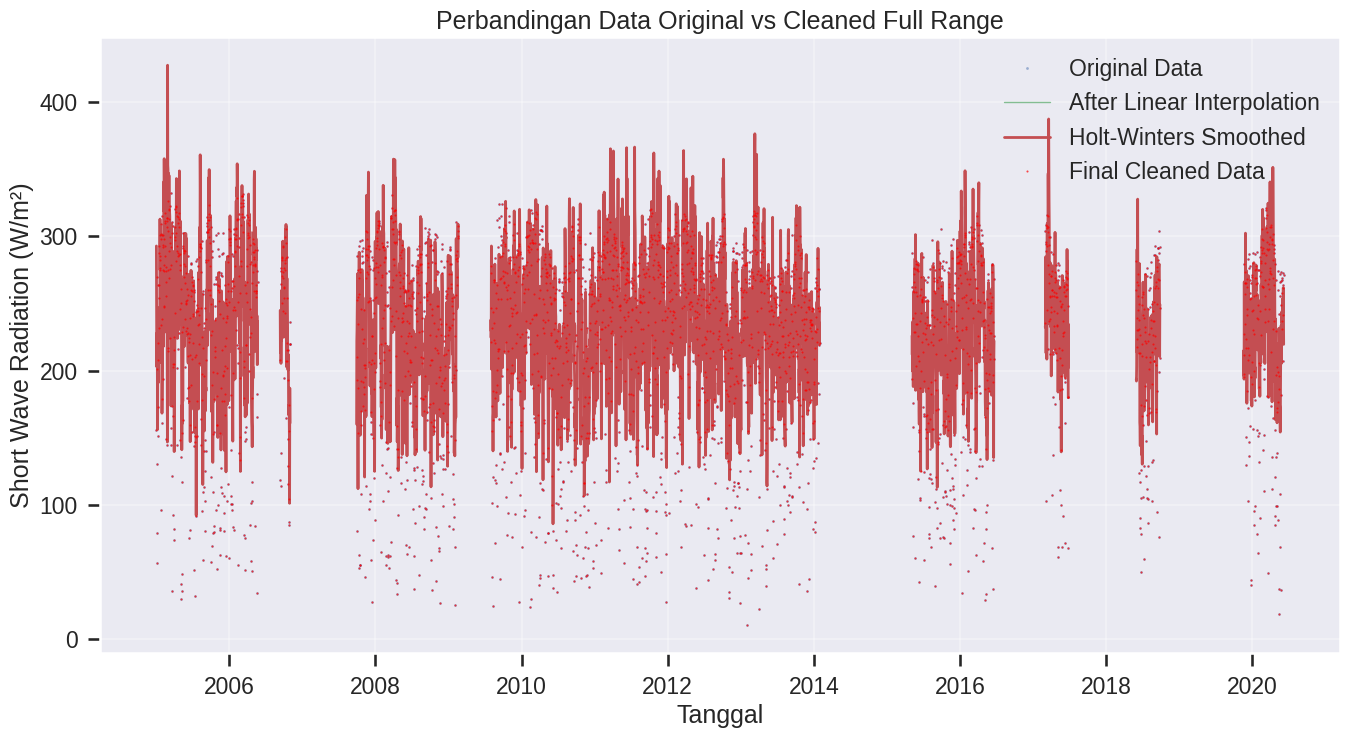

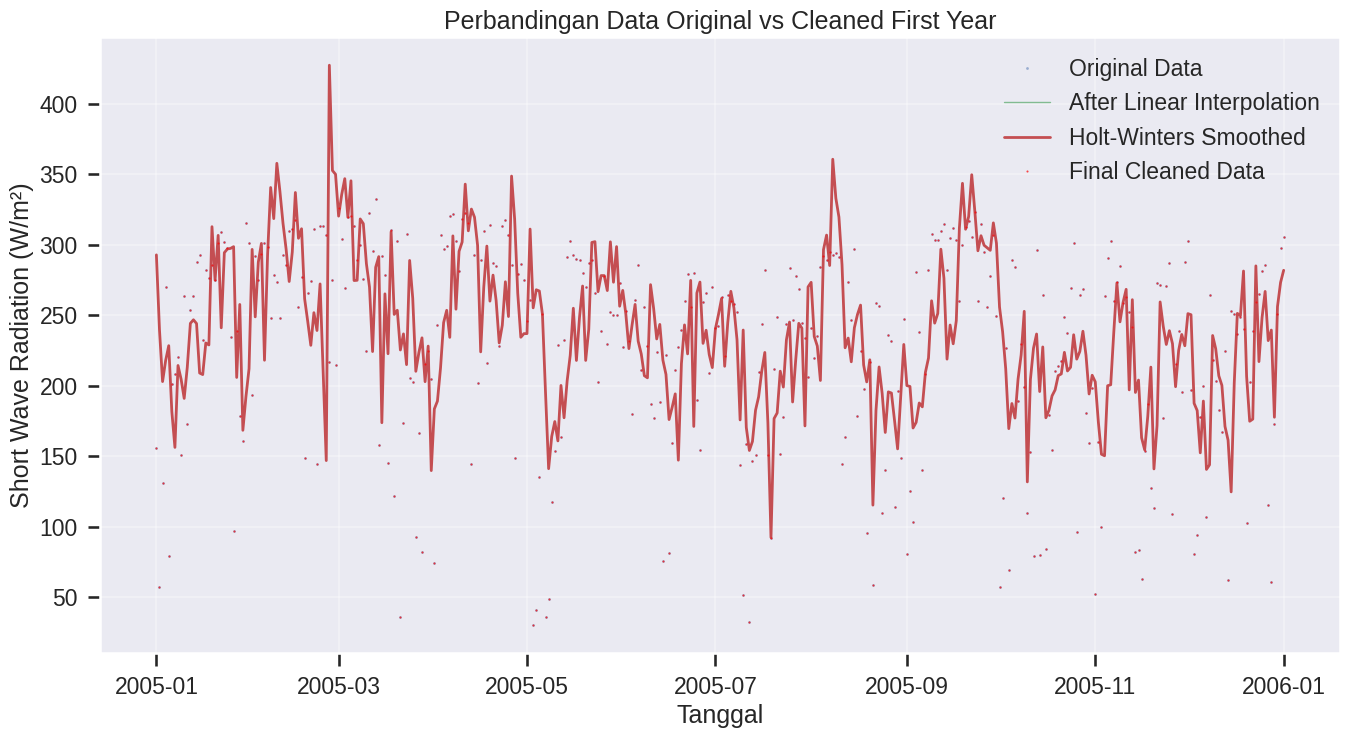

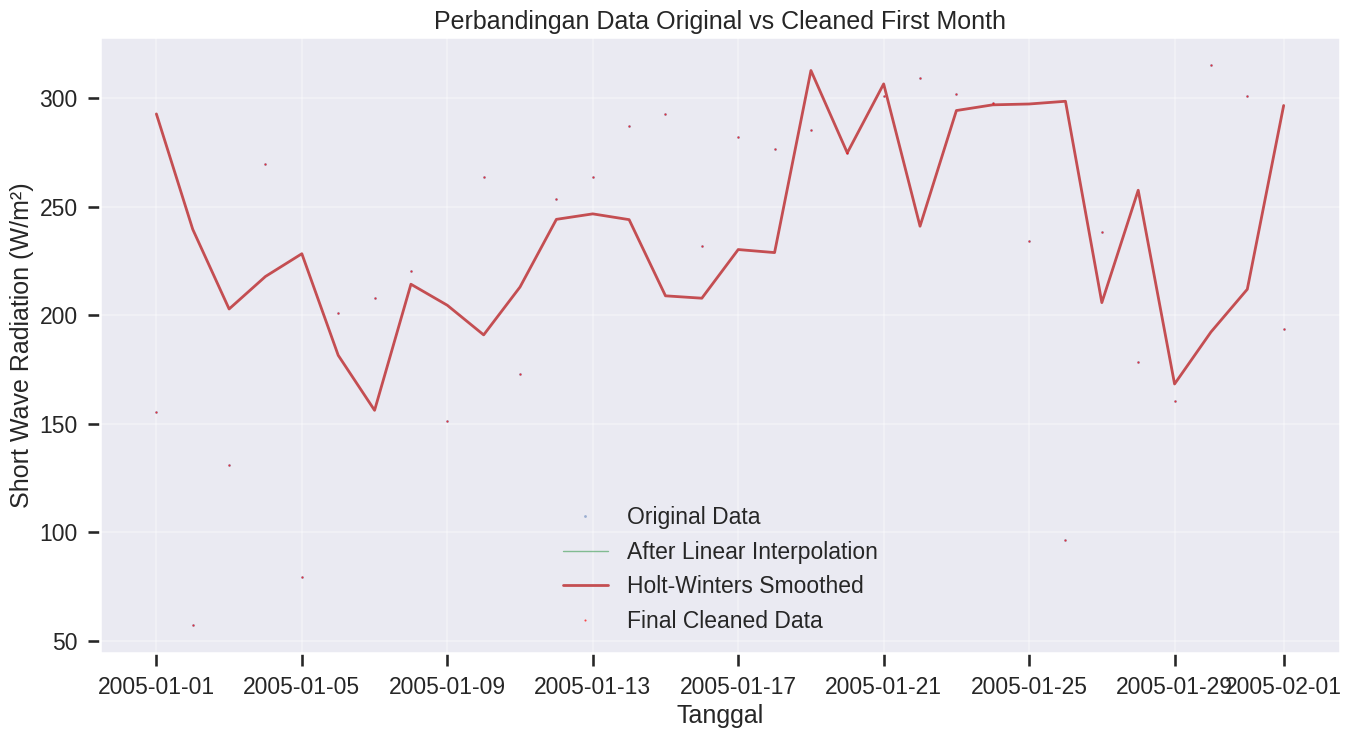

In [47]:
# Plot untuk keseluruhan data
plot_ts_comparison(title_suffix="Full Range")

# Plot untuk tahun pertama sebagai contoh detil
first_year_end = pd.to_datetime(merged_df.index.min()) + pd.DateOffset(years=1)
plot_ts_comparison(merged_df.index.min(), first_year_end, title_suffix="First Year")

# Plot untuk contoh periode 1 bulan untuk melihat detil harian
month_end = pd.to_datetime(merged_df.index.min()) + pd.DateOffset(months=1)
plot_ts_comparison(merged_df.index.min(), month_end, title_suffix="First Month")

In [48]:
# 8. Evaluasi Hasil Cleaning
print("\n--- LANGKAH 8: EVALUASI HASIL CLEANING ---")

# Hitung statistik data original vs cleaned
original_stats = df['SWRad'].describe()
cleaned_stats = merged_df['SWRad'].describe()

# Tampilkan perbandingan
stats_comparison = pd.DataFrame({
    'Original': original_stats,
    'Cleaned': cleaned_stats
})
print("Perbandingan Statistik Original vs Cleaned:")
print(stats_comparison)


--- LANGKAH 8: EVALUASI HASIL CLEANING ---
Perbandingan Statistik Original vs Cleaned:
          Original      Cleaned
count  3545.000000  3559.000000
mean    222.076559   222.199250
std      70.980748    70.947736
min      10.480000    10.480000
25%     179.910000   180.070000
50%     243.750000   244.100000
75%     276.380000   276.445000
max     332.160000   332.160000


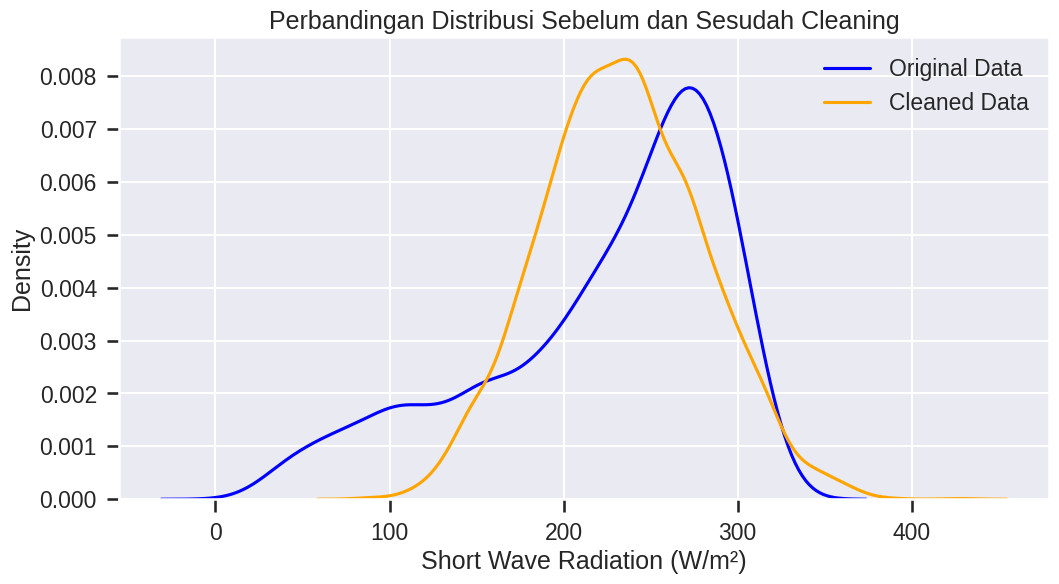

In [ ]:
# Plot distribusi data sebelum dan sesudah cleaning
plt.figure(figsize=(12, 6))
sns.kdeplot(df['SWRad'].dropna(), label='Original Data', color='blue')
sns.kdeplot(merged_df['SWRad_smoothed'].dropna(), label='Cleaned Data', color='orange')
plt.title('Perbandingan Distribusi Sebelum dan Sesudah Cleaning')
plt.xlabel('Short Wave Radiation (W/m²)')
plt.ylabel('Density')
# plt.savefig('distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

In [ ]:
# 10. Simpan hasil preprocessing
print("\n--- LANGKAH 10: SIMPAN HASIL PREPROCESSING ---")

# Persiapkan data untuk disimpan
output_df = merged_df[['SWRad', 'SWRad_original', 'SWRad_smoothed', 'StDev', 'Max', 'Q', 'S']]

# Tambahkan kolom Year, Month, Day
output_df['Year'] = output_df.index.year
output_df['Month'] = output_df.index.month
output_df['Day'] = output_df.index.day


--- LANGKAH 10: SIMPAN HASIL PREPROCESSING ---


/tmp/ipykernel_13973/1154855329.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Year'] = output_df.index.year
/tmp/ipykernel_13973/1154855329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Month'] = output_df.index.month
/tmp/ipykernel_13973/1154855329.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [57]:
output_df = ts_data_filled.copy()

# Reset index to get 'Date' as a column
output_df.reset_index(inplace=True)

# Extract Year, Month, and Day from the 'Date' column
output_df['Year'] = output_df['Date'].dt.year
output_df['Month'] = output_df['Date'].dt.month
output_df['Day'] = output_df['Date'].dt.day

# Replace 'SWRad' with 'SWRad_original'
output_df['SWRad_original'] = output_df['SWRad']
output_df.drop(columns=['SWRad'], inplace=True)

# Reorder columns to match the desired format
output_df = output_df[['Date', 'Year', 'Month', 'Day', 'SWRad_original', 'SWRad_smoothed', 'StDev', 'Max', 'Q', 'S']]

# Save to CSV
output_csv = '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy_cleaned.csv'
output_df.to_csv(output_csv, index=False)
print(f"Data berhasil disimpan ke {output_csv}")

# Save to Excel with appropriate formatting
output_excel = '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy_cleaned.xlsx'
writer = pd.ExcelWriter(output_excel, engine='xlsxwriter')
output_df.to_excel(writer, sheet_name='Cleaned Data', index=False)

# Adjust column widths
workbook = writer.book
worksheet = writer.sheets['Cleaned Data']
for i, col in enumerate(output_df.columns):
    # Find the maximum length of the column
    max_len = max(output_df[col].astype(str).map(len).max(), len(col)) + 2
    worksheet.set_column(i, i, max_len)  # i because index column is not included

# Save workbook
writer.close()
print(f"Data berhasil disimpan ke {output_excel} dengan format yang sesuai")

Data berhasil disimpan ke /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy_cleaned.csv
Data berhasil disimpan ke /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy_cleaned.xlsx dengan format yang sesuai
